In [1]:
import pmagpy
import pmagpy.pmagplotlib as pmagplotlib
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import pmagpy.contribution_builder as cb
from pmagpy import convert_2_magic as convert
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from pathlib import Path
import vgptools
%matplotlib inline

In [2]:
home = Path(os.getcwd())
thermal_folder = home/'data/stillwater_thermal'      # Directory for data files (Excel or csv) from publications
magic_folder = home/'magic'    # Directory for MagIC output

## Selkin et al., 2008
Selkin, P. A., Gee, J. S., Meurer, W. P., & Hemming, S. R. (2008). Paleointensity record from the 2.7 Ga Stillwater Complex, Montana. Geochemistry Geophysics Geosystems, 9(12). https://doi.org/10.1029/2008GC001950

In [3]:
## Selkin et al (2008)
#%%capture measurements_conversion_log
# Capture output to measurements_conversion_log

## Convert .mag Files to MagIC format (measurements)
mag_columns=['specimen','treatment','dir_csd','intensity','dir_dec','dir_inc','metadata','i']
search_pattern = re.compile('.*((?!short).)\.mag$') # This is the suffix for a mag file
mag_name_lookup=pd.DataFrame([])
converted=list([])
omit_prefixes=['lm']
measurements_df=pd.DataFrame([])

method_codes='LT-T-Z'
citations='https://doi.org/10.1029/2008GC001950'
thermal=True

# Traverse through thermal_folder looking for .mag files
for folder in os.walk(thermal_folder):
    if folder[0] is not thermal_folder: # Skip the base folder
        print('Working on directory: {}'.format(folder[0])) 
        # Look for .mag files and list them
        file_list = list(filter(search_pattern.match,folder[2]))
        #converted=converted+file_list
        for mag_file in file_list:
            file_base = re.sub(".mag","",mag_file)
            #print('\t{}'.format(file_base))
            file_path=Path(folder[0])/mag_file
            with open(file_path) as f:
                    mag_df=pd.read_csv(file_path,sep='\s+',header=None,names=mag_columns)
                    #print('\t treatments:{}'.format(mag_df['treatment'].unique()))
                    # Some lm samples are in there... get rid of those
                    for pref in omit_prefixes:
                        temp_df=mag_df[~mag_df['specimen'].str.contains(pref)]
                    #print('\t specimens:{}'.format(temp_df['specimen'].unique()))
                    temp_df['metadata']=temp_df['metadata']+' '+temp_df['i']
                    temp_meta=temp_df['metadata'].str.split(';',expand=True)
                    temp_df['timestamp']=temp_meta[0]+' '+temp_meta[1]
                    temp_df['mag_n_orient']=temp_meta[2].str.extract('([1248])').astype('int')
                    temp_df['timestamp']=pd.to_datetime(temp_df['timestamp'])
                    temp_df['magn_volume']=(temp_df['intensity']/10)*(10**3)
                    temp_df.drop(columns=['i','metadata','intensity'],inplace=True)
                    if thermal:
                        temp_df.rename(columns={'treatment':'treat_temp'})
                    temp_df['method_codes']=method_codes
                    temp_df['citations']=citations
                    #print('\t DataFrame:\n{}'.format(temp_df.head()))
                    print ('\t{}: Converted {} measurements of {} specimens ({} treatment steps).'.format(file_base,temp_df.shape[0],temp_df['specimen'].unique().shape[0],
                                                                                               temp_df['treatment'].unique().shape[0]))
                    measurements_df=pd.concat([measurements_df,temp_df],ignore_index=True,axis=0)

Working on directory: C:\Users\paselkin\Dropbox\Research\intrusion_magnetics\published-data-to-magic\data\stillwater_thermal
Working on directory: C:\Users\paselkin\Dropbox\Research\intrusion_magnetics\published-data-to-magic\data\stillwater_thermal\cleaned raw
	sw1: Converted 590 measurements of 33 specimens (16 treatment steps).
	sw2: Converted 607 measurements of 33 specimens (16 treatment steps).
	sw3: Converted 650 measurements of 36 specimens (17 treatment steps).
	sw4: Converted 569 measurements of 36 specimens (17 treatment steps).
	sw5: Converted 514 measurements of 33 specimens (17 treatment steps).
	sw6: Converted 505 measurements of 31 specimens (17 treatment steps).
	sw7: Converted 510 measurements of 30 specimens (17 treatment steps).
Working on directory: C:\Users\paselkin\Dropbox\Research\intrusion_magnetics\published-data-to-magic\data\stillwater_thermal\thelzero raw
	clthel1zeros: Converted 412 measurements of 29 specimens (12 treatment steps).
	clthel2zeros: Converte

In [4]:
measurements_df['sample']=measurements_df['specimen'].str.extract('(\D+\d+[a-z])\d*')
measurements_df['site']=measurements_df['sample'].str.extract('(\D+\d+)[a-z]')
display(measurements_df.head())

,specimen,treatment,dir_csd,dir_dec,dir_inc,timestamp,mag_n_orient,magn_volume,method_codes,citations,sample,site
0,cl059a3,0.0,1.1,1.8,47.6,2002-03-27 18:17:00,8,2.0540,LT-T-Z,https://doi.org/10.1029/2008GC001950,cl059a,cl059
1,cl059a3,100.0,1.2,359.9,47.4,2002-03-28 20:34:00,8,1.9130,LT-T-Z,https://doi.org/10.1029/2008GC001950,cl059a,cl059
2,cl059a3,200.0,1.2,0.5,46.1,2002-03-29 14:33:00,8,1.4100,LT-T-Z,https://doi.org/10.1029/2008GC001950,cl059a,cl059
3,cl059a3,300.0,1.3,2.3,45.5,2002-04-01 14:01:00,8,1.1840,LT-T-Z,https://doi.org/10.1029/2008GC001950,cl059a,cl059
4,cl059a3,400.0,1.3,2.6,44.5,2002-04-01 22:49:00,8,0.9411,LT-T-Z,https://doi.org/10.1029/2008GC001950,cl059a,cl059


In [15]:
azdip_columns=['sample', 'azimuth', 'dip','bed_strike','bed_dip','vert_rotation']
azdip_df=pd.read_csv(thermal_folder/'still-final.az',names=azdip_columns,header=None,delim_whitespace=True)

In [6]:
strat_columns=['site','height']
strat_df=pd.read_csv(thermal_folder/'strat.pos',sep='\s+',header=None,names=strat_columns,skiprows=1)
print(strat_df.head())

    site  height
0  cl001  -11.17
1  cl002  -10.95
2  cl003  -10.70
3  cl004  -10.48
4  cl005  -10.29


In [7]:
measurements_df['specnum']=measurements_df['specimen']+'-'+\
                            ((measurements_df['treatment']<measurements_df['treatment'].shift()).cumsum()).astype(str)
print(measurements_df)

        specimen  treatment  dir_csd  dir_dec  dir_inc           timestamp  \
0        cl059a3        0.0      1.1      1.8     47.6 2002-03-27 18:17:00   
1        cl059a3      100.0      1.2    359.9     47.4 2002-03-28 20:34:00   
2        cl059a3      200.0      1.2      0.5     46.1 2002-03-29 14:33:00   
3        cl059a3      300.0      1.3      2.3     45.5 2002-04-01 14:01:00   
4        cl059a3      400.0      1.3      2.6     44.5 2002-04-01 22:49:00   
...          ...        ...      ...      ...      ...                 ...   
11218  smc9916j4      560.0      0.5    127.5    -25.1 2003-03-24 09:51:00   
11219  smc9916j4      565.0      0.5    127.7    -24.7 2003-03-25 11:36:00   
11220  smc9916j4      570.0      0.5    127.6    -25.7 2003-03-27 11:38:00   
11221  smc9916j4      575.0      0.5    128.5    -24.9 2003-03-27 19:58:00   
11222  smc9916j4      580.0      0.5    125.9    -24.1 2003-03-31 13:37:00   

       mag_n_orient  magn_volume method_codes  \
0             

In [8]:
#picks_df=measurements_df['specnum'].drop_duplicates().reset_index()
#picks_df['c0_name']='C2'
#picks_df['c0_start']=555
#picks_df['c0_stop']=580
#picks_df['c1_name']='C1'
#picks_df['c1_start']=500
#picks_df['c1_stop']=550
#picks_df.to_csv(thermal_folder/'picks.csv')
picks_df=pd.read_csv(thermal_folder/'picks.csv',index_col=0)

[[0.0, 52.7, -6.4, 0.1026, 'g'], [200.0, 49.7, -23.2, 0.1125, 'g'], [450.0, 47.0, -35.5, 0.12510000000000002, 'g'], [500.0, 44.5, -36.5, 0.1202, 'g'], [525.0, 43.6, -30.2, 0.09385, 'g'], [550.0, 42.2, -19.4, 0.06641000000000001, 'g'], [555.0, 38.3, -4.8, 0.05054, 'g'], [560.0, 36.1, -4.6, 0.04651, 'g'], [565.0, 27.1, -4.4, 0.029, 'g'], [570.0, 25.0, -5.3, 0.024159999999999997, 'g'], [575.0, 23.1, -5.8, 0.019430000000000003, 'g']]
Working on cl001a1(C2): 555.0[6]-580.0[10]
Working on cl001a1(C1): 500.0[3]-550.0[5]


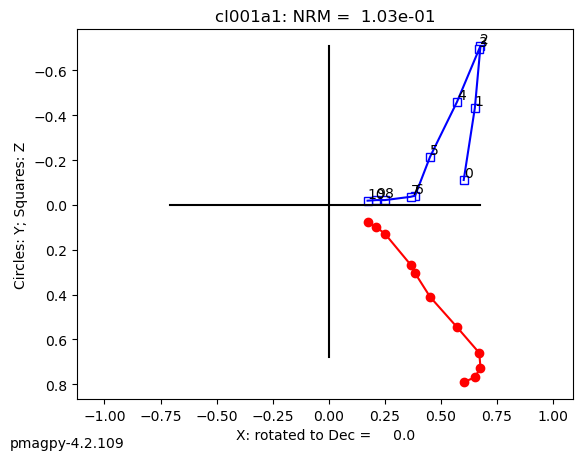

In [37]:
specimens_groups=measurements_df.groupby('specnum')
specimens_df=pd.DataFrame([])
pp = PdfPages(thermal_folder/'specimens_core.pdf')
for specnum,specimen_group in specimens_groups:
    specimen=specimen_group['specimen'].iloc[0]
    picks=picks_df[picks_df['specnum']==specnum].values.flatten().tolist()[2:]
    data_df=specimen_group[['treatment','dir_dec','dir_inc','magn_volume']]
    data_df['flag']='g'
    data_block=data_df.values.tolist()
    print(data_block)
    f=plt.figure(1)
    pmagplotlib.plot_zij(1,data_block,s=specimen,angle=0)
    pp.savefig(f)
    for component, start, stop in zip(*[iter(picks)]*3):
        start=float(start)
        stop=float(stop)
        if (data_df['treatment'].max()>=start):
            ibegin=data_df[data_df['treatment'].ge(start)].index[0]-data_df['treatment'].index[0]
            iend=data_df[data_df['treatment'].le(stop)].index[-1]-data_df['treatment'].index[0]
            print('Working on {}({}): {}[{}]-{}[{}]'.format(specimen,component,start,ibegin,stop,iend))
            result_dict=pmag.domean(data_block,ibegin,iend,'DE-BFL')
            specimen_df=pd.DataFrame(result_dict)
            specimen_df.drop(columns=['center_of_mass','specimen_direction_type'],inplace=True)
            specimen_df['specimen']=specimen
            specimen_df['specnum']=specnum
            specimen_df['component']=component
            specimens_df=pd.concat([specimens_df,specimen_df.drop_duplicates()],axis=0)
    break
pp.close()           

     specimen  treatment  dir_csd  dir_dec  dir_inc           timestamp  \
4749  cl001a1        0.0      0.6     52.7     -6.4 2001-04-20 16:25:00   
4750  cl001a1      200.0      0.7     49.7    -23.2 2001-04-23 14:06:00   
4751  cl001a1      450.0      0.9     47.0    -35.5 2001-04-25 15:15:00   
4752  cl001a1      500.0      0.9     44.5    -36.5 2001-04-28 17:45:00   
4753  cl001a1      525.0      0.7     43.6    -30.2 2001-05-02 13:02:00   
4754  cl001a1      550.0      0.6     42.2    -19.4 2001-05-19 12:21:00   
4755  cl001a1      555.0      0.5     38.3     -4.8 2001-05-23 14:09:00   
4756  cl001a1      560.0      0.4     36.1     -4.6 2001-06-01 15:55:00   
4757  cl001a1      565.0      0.6     27.1     -4.4 2001-06-07 18:43:00   
4758  cl001a1      570.0      0.7     25.0     -5.3 2001-06-19 12:11:00   
4759  cl001a1      575.0      0.7     23.1     -5.8 2001-12-27 13:07:00   

      mag_n_orient  magn_volume method_codes  \
4749             4      0.10260       LT-T-Z   
475

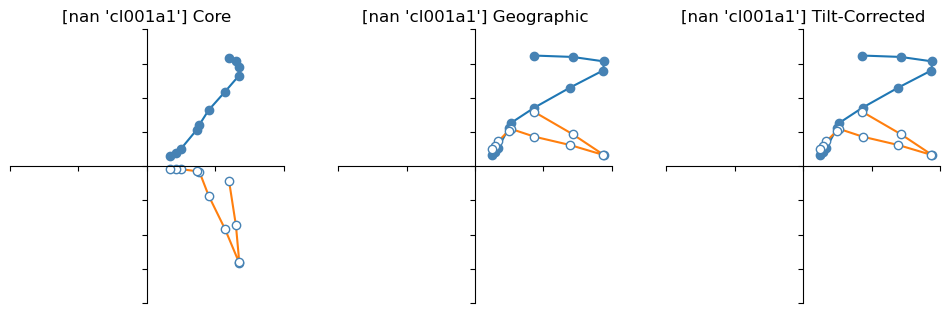

In [38]:
print(specimen_group)
sample=specimen_group['specimen'].unique()[0][:-1]
azdip_row=azdip_df[azdip_df['sample']==sample]
print(azdip_row)

def dataframe_dir2cart(specimen_group_orig):
    specimen_group=specimen_group_orig.copy()
    try:
            inrm=specimen_group['treatment'].idxmin(skipna=True)
            fact = (1./specimen_group.loc[inrm,'magn_volume'])   # normalize to NRM=1
    except ZeroDivisionError:
            fact = 1.
    specimen_group['magn_volume']=fact*specimen_group['magn_volume']
    if 'flag' in specimen_group.columns:
        gdata = specimen_group[specimen_group['flag'].str.contains('g')]
        bdata = specimen_group[specimen_group['flag'].str.contains('b')]
    else:
        gdata = specimen_group.copy()
    core_data = gdata[['dir_dec', 'dir_inc', 'magn_volume']].values
    core_XYZ = pd.DataFrame(pmag.dir2cart(core_data))
    core_XYZ.columns = ['core_x', 'core_y', 'core_z']
    r = core_XYZ.copy()
    if 'geo_dec' in specimen_group.columns:
        geo_data = gdata[['geo_dec', 'geo_inc', 'magn_volume']].values
        geo_XYZ = pd.DataFrame(pmag.dir2cart(geo_data))
        geo_XYZ.columns = ['geo_x', 'geo_y', 'geo_z']
        r=pd.concat([r,geo_XYZ],axis=1)
    if 'tilt_dec' in specimen_group.columns:
        tilt_data = gdata[['tilt_dec', 'tilt_inc', 'magn_volume']].values
        tilt_XYZ = pd.DataFrame(pmag.dir2cart(geo_data))
        tilt_XYZ.columns = ['tilt_x', 'tilt_y', 'tilt_z']
        r=pd.concat([r,tilt_XYZ],axis=1)

    return r

def series_digeo(specimen_row,azdip_row):
    if not(np.isnan(azdip_row['vert_rotation'][0])):
        specimen_row['dir_dec']=(specimen_row['dir_dec']+azdip_row['vert_rotation'])%360.
    r=pd.Series(pmag.dogeo(specimen_row['dir_dec'],specimen_row['dir_inc'],azdip_row['azimuth'],azdip_row['dip']))
    r.rename({0:'geo_dec',1:'geo_inc'},inplace=True)
    s=pd.Series(pmag.dotilt(r['geo_dec'],r['geo_inc'],(azdip_row['bed_strike'][0]+90.)%360.,azdip_row['bed_dip'][0]))
    s.rename({0:'tilt_dec',1:'tilt_inc'})
    r=pd.concat([r,s])
    return r

def center_axes(ax):
    # Move left y-axis and bottom x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
        
    abs_max = abs(max(list(ax.get_ylim())+list(ax.get_xlim()), key=abs))
    ax.set_ylim(ymin=-abs_max, ymax=abs_max)
    ax.set_xlim(xmin=-abs_max, xmax=abs_max)
    
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    ax.set_aspect('equal', adjustable='box')

def series_zijderveld(ext_specimen_group,plots=None):
    specimen_group=ext_specimen_group.copy()
    if plots is None:
        plots='c'
        if 'geo_dec' in specimen_group.columns:
            plots=plots+'g'
        if 'tilt_dec'in specimen_group.columns:
            plots=plots+'t'
    nplots=len(plots)
    fig,axs=plt.subplots(nrows=1,ncols=nplots,figsize=(12,4))
    id=specimen_group['specimen'].unique()
    for iplot,coords in enumerate(plots):
        center_axes(axs[iplot])
        data=pd.DataFrame([])
        print(data)
        if (coords=='c'):
            data=specimen_group[['core_x','core_y','core_z']].copy()
            axs[iplot].set_title('{} Core'.format(id))
        elif (coords=='g'):
            data=specimen_group[['geo_x','geo_y','geo_z']].copy()
            axs[iplot].set_title('{} Geographic'.format(id))
        elif (coords=='t'):
            data=specimen_group[['tilt_x','tilt_y','tilt_z']].copy()
            axs[iplot].set_title('{} Tilt-Corrected'.format(id))

        data.columns=['x','y','z']
        axs[iplot].plot(data['x'],data['y'],'o-',mfc='steelblue',mec='steelblue')
        axs[iplot].plot(data['x'],data['z'],'o-',mfc='white',mec='steelblue')
    return fig

specimen_group[['geo_dec','geo_inc','tilt_dec','tilt_inc']]=specimen_group.apply(lambda x:series_digeo(x,azdip_row),
                                                                               axis=1,result_type='expand')
print(dataframe_dir2cart(specimen_group))
specimen_group=pd.concat([specimen_group,dataframe_dir2cart(specimen_group)],axis=1)
fig=series_zijderveld(specimen_group)
plt.show(fig)

In [29]:
pmagplotlib.plot_zij??